In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import os
from pandas.core.computation.check import NUMEXPR_INSTALLED
import openpyxl
from datetime import datetime
import re
import scipy

plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

d = 'D:/中泰证券数据分析/3'
os.chdir(d)

F:\Anaconda\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# 处理表格“公开市场操作”

In [2]:
OMO = pd.read_csv('公开市场操作.csv')
OMO = OMO.drop(index = OMO[(OMO['日期'].isnull()) | (OMO['操作类型'].isnull())].index)
print(OMO.isnull().sum())
OMO.tail()

日期          0
操作类型        0
操作方向        0
发行总量(亿元)    0
期限          0
利率(%)       0
利率变动bp      0
发行日期        0
到期日期        0
现金流发生日      0
招标方式        0
央票代码        0
dtype: int64


,日期,操作类型,操作方向,发行总量(亿元),期限,利率(%),利率变动bp,发行日期,到期日期,现金流发生日,招标方式,央票代码
4994,2022-12-29,逆回购,到期,40.00,7D,2.00,0.00,2022-12-22,2022-12-29,2022-12-29,利率招标,--
4995,2022-12-29,CBS,回笼,50.00,3M,2.35,0.00,2022-09-29,2022-12-29,2022-12-29,固定费率数量招标,2201009S
4996,2022-12-30,逆回购,发行,"1,830.00",7D,2.00,0.00,2022-12-30,2023-01-06,2023-01-06,利率招标,--
4997,2022-12-30,逆回购,到期,20.00,7D,2.00,0.00,2022-12-23,2022-12-30,2022-12-30,利率招标,--
4998,--,净投放,--,"27,550.00",--,--,--,--,--,--,--,--


In [3]:
OMO[1:2].index.duplicated()

array([False])

In [4]:
print(OMO.columns)

Index(['日期', '操作类型', '操作方向', '发行总量(亿元)', '期限', '利率(%)', '利率变动bp', '发行日期',
       '到期日期', '现金流发生日', '招标方式', '央票代码'],
      dtype='object')


找到并统计每一列未被记录的数据(--)进行处理. 对于日期，可以通过上一日加一或下一日减一补全.

In [5]:
print('The number of unrecorded values are:\n\n', OMO[OMO == '--'].count())

The number of unrecorded values are:

 日期             1
操作类型           0
操作方向           1
发行总量(亿元)       0
期限             1
利率(%)          1
利率变动bp        79
发行日期           1
到期日期        2717
现金流发生日         1
招标方式          19
央票代码        4794
dtype: int64


In [6]:
for i in OMO[OMO['日期'] == '--'].index:
    OMO.loc[i, '日期'] = pd.to_datetime(OMO.loc[i - 1, '日期']) + pd.to_timedelta(1, unit = 'd') 
    
OMO['日期'] = pd.to_datetime(OMO['日期'])
OMO['日期'].isnull().sum()

0

# 公司债券利率与公开市场操作

In [7]:
BoC = pd.read_csv('证券公司债.csv')

In [8]:
BoC = BoC.drop(index = BoC[BoC['发行日期'].isnull()].index)

In [9]:
BoC['发行日期'] = pd.to_datetime(BoC['发行日期'])

In [10]:
t_idx = BoC[BoC['起息日期'] == '--'].index
BoC.loc[t_idx, '起息日期'] = pd.to_datetime(BoC.loc[t_idx[0] - 1, '起息日期']) + pd.to_timedelta(1, unit = 'd')
BoC.loc[[t_idx[0] - 1, t_idx[0]], '起息日期']

1551             2016-01-19
1552    2016-01-20 00:00:00
Name: 起息日期, dtype: object

In [11]:
t_idx = BoC[BoC['到期日期'] == '--'].index
BoC.loc[t_idx, '到期日期'] = pd.to_datetime(pd.to_datetime(BoC.loc[t_idx[0] - 1, '到期日期']) + pd.to_timedelta(1, unit = 'd'))
BoC.loc[[t_idx[0] - 1, t_idx[0]], '到期日期']

1551             2016-10-15
1552    2016-10-16 00:00:00
Name: 到期日期, dtype: object

In [12]:
BoC['起息日期'] = pd.to_datetime(BoC['起息日期'].astype('string'))
BoC['到期日期'] = pd.to_datetime(BoC['到期日期'].astype('string'))    

In [13]:
# BoC['计息期限'] = BoC['到期日期'] - BoC['发行日期']
# BoC['计息期限']

In [14]:
BoC.columns

Index(['债券代码', '债券简称', '发行日期', '起息日期', '到期日期', '发行期限(年)', '特殊期限(年)', '发行总额(亿)',
       '当期票面利率(%)', '票面利率说明', '最新主体评级', '最新债项评级', '利率类型', '付息频率(月/次)', '发行方式',
       '主承销商', '特殊条款', '特殊条款说明', '债券全称', '发行人', '交易市场', '债券类型', '债券代码列表'],
      dtype='object')

## 对市场操作编码

在*公开市场操作*表，将市场操作编码. 先建立字典将**操作类型**与**操作方向**匹配. 除去属于期末统计性质的“净投放”.

In [15]:
OMO = OMO.drop(index = OMO[OMO['操作类型'] == '净投放'].index)

In [16]:
all_oprt = {}
for subs in OMO.groupby(by = '操作类型'):
    all_oprt[subs[0]] = subs[1]['操作方向'].unique()
all_oprt

{'CBS': array(['投放', '回笼'], dtype=object),
 'MLF': array(['投放', '回笼'], dtype=object),
 'SLO': array(['投放', '回笼'], dtype=object),
 'TMLF': array(['投放', '回笼'], dtype=object),
 '国库现金定存': array(['到期', '发行'], dtype=object),
 '央行票据': array(['到期', '发行'], dtype=object),
 '正回购': array(['到期', '发行'], dtype=object),
 '逆回购': array(['发行', '到期'], dtype=object)}

根据市场操作对流动性的影响：按照不同政策的不同作用时间 **（期限）** 设置不同长度的作用数组：按照不同方向，即对流动性影响的不同设置递减正值（提高流动性）或递增负值（减少流动性）：

**CBS央行票据互换工具**：投放增加流动性，回笼减少流动性；  
**MLF中期借贷便利/TMLF定向中期借贷便利**：投放增加流动性，回笼减少；  
**SLO短期流动性调节工具**：投放增加，回笼减少；  
**国库现金定存**：到期减少，发行增加；  
**央行票据**：到期增加，发行减少；  
**正回购**：到期增加，发行减少；  
**逆回购**：发行增加；到期减少；

先对各个操作与方向的流动性影响定性：如果发行或投放操作增加流动性，则为1，减少则为-1， 在发行期限上向0均匀减小或增大。

In [17]:
# code_oprt = all_oprt.copy()
# for k, v in code_oprt.items():
#     if k in ['CBS', 'MLF', 'TMLF', 'SLO', '央行票据', '正回购', '逆回购']:
#         code_oprt[k] = {v[0]: 1, v[1]: 0}
#     elif k == '国库现金定存':
#         code_oprt[k] = {v[0]: 0, v[1]: 1}
# code_oprt

In [18]:
code_oprt = all_oprt.copy()
for k, v in code_oprt.items():
    if k in ['CBS', 'MLF', 'TMLF', 'SLO', '逆回购']:
        code_oprt[k] = {v[0]: 1, v[1]: 0}
    elif k in ['央行票据', '正回购']:
        code_oprt[k] = {v[0]: 0, v[1]: -1}
    elif k == '国库现金定存':
        code_oprt[k] = {v[0]: 0, v[1]: 1}
code_oprt

{'CBS': {'投放': 1, '回笼': 0},
 'MLF': {'投放': 1, '回笼': 0},
 'SLO': {'投放': 1, '回笼': 0},
 'TMLF': {'投放': 1, '回笼': 0},
 '国库现金定存': {'到期': 0, '发行': 1},
 '央行票据': {'到期': 0, '发行': -1},
 '正回购': {'到期': 0, '发行': -1},
 '逆回购': {'发行': 1, '到期': 0}}

随后创建时间轴。

In [19]:
t_axis = [dt for dt in pd.date_range(OMO['发行日期'].min(), OMO['日期'].max())] # 先创建时间域
OMO.columns

Index(['日期', '操作类型', '操作方向', '发行总量(亿元)', '期限', '利率(%)', '利率变动bp', '发行日期',
       '到期日期', '现金流发生日', '招标方式', '央票代码'],
      dtype='object')

再对不同政操作策分别创建时间轴，记录政策发起时间和其对流动性影响力的变化，储存于表格。

对操作的编码有两种：
1. 在时间域选出不同政策实施的一对时间、两次操作方向。定位一对操作，方法是：因为对于给定的一种政策，在发行-到期两个时间点不会重复操作，故定位有相同“发行-到期日期”的一组（两行）数据；又知道一对操作是存在必然先后顺序的（如投放-回笼），所以提取独立发行日期和到期日期以直接定位作用时间段。

2. 按同一央票代码定位。当到期日期不存在，那么就难以通过发行-到期确定一对操作，则考虑用央票代码查找。

**如有以上两种方法都无法确定的则跳过编码。**

“发行-到期日期”只是计划日期，但到期日可能是逾期的，所以不能仅仅依照计划日期匹配，需要在找到两个实际结算日期（“日期”）后按照准确到期日计算。

同时，创建一列记录每行数据是否被编码。

In [20]:
def terms(t):
    t = t.strip()
    if t[-1] == 'M':
        return int(t[: -1]) * 30
    elif t[-1] == 'Y':
        return int(t[: -1]) * 365
    else: return int(t[: -1])

In [21]:
Oprt_taxis = pd.DataFrame(columns = all_oprt.keys(), index = t_axis)
Oprt_taxis.fillna(0, inplace = True)
for i in Oprt_taxis.columns:
    oprti = OMO[OMO['操作类型'] == i].copy()
    dpair = {}

    for p in oprti[['发行日期', '到期日期']].values:
        dpair[p[0] + ' ' + p[1]] = p
    for tpair in dpair.values(): 
#        print(tpair)

#         print(oprti[oprti['日期'] == tpair[0]]['操作方向'].values)
#         break
#     break
        tgt = oprti[(oprti['发行日期'] == tpair[0]) & (oprti['到期日期'] == tpair[1])]
        if tpair[1] != '--':
            if len(tgt) == 2:
                Oprt_taxis.loc[pd.date_range(pd.to_datetime(tgt['日期'].values[0]), pd.to_datetime(tgt['日期'].values[1])), i] \
                += np.linspace(code_oprt[i][tgt['操作方向'].values[0]], code_oprt[i][tgt['操作方向'].values[1]], 
                                num = abs((pd.to_datetime(tgt['日期'].values[0]) - pd.to_datetime(tgt['日期'].values[1])).days) + 1)
            elif len(tgt) == 1:
                if tgt['操作方向'].values[0] == '到期' or tgt['操作方向'].values[0] == '回笼':
                    Oprt_taxis.loc[pd.date_range(tgt['日期'].values[0] - pd.to_timedelta(terms(tgt['期限'].values[0]) - 1, unit = 'd'), tgt['日期'].values[0]), i]\
                    += np.linspace((-1 * code_oprt[i][tgt['操作方向'].values[0]] + 1), code_oprt[i][tgt['操作方向'].values[0]], 
                    num = terms(tgt['期限'].values[0]))[max(0, -(tgt['日期'].values[0] - pd.to_timedelta(terms(tgt['期限'].values[0]), unit = 'd') - pd.to_datetime(Oprt_taxis.index[0])).days) : ]
                else:
                    Oprt_taxis.loc[pd.date_range(pd.to_datetime(tgt['日期'].values[0]), Oprt_taxis.index[-1]), i] += np.linspace(code_oprt[i][tgt['操作方向'].values[0]], 
                    (code_oprt[i][tgt['操作方向'].values[0]]) * (-1) + 1, 
                    num = terms(tgt['期限'].values[0]))[: abs((pd.to_datetime(Oprt_taxis.index[-1]) - pd.to_datetime(tgt['日期'].values[0])).days) + 1]
            OMO.loc[tgt.index, 'if encoded'] = True

        else:
            if len(tgt) == 2:
                tgt_idx = tgt[(tgt['操作方向'] == '回笼') | (tgt['操作方向'] == '到期')].index[0]
                Oprt_taxis.loc[pd.date_range(pd.to_datetime(tgt.loc[tgt_idx, '发行日期']), pd.to_datetime(tgt.loc[tgt_idx, '日期'])), i] += np.linspace(code_oprt[i][tgt['操作方向'].values[0]], 
                    (code_oprt[i][tgt['操作方向'].values[1]]), 
                    num = int(abs(pd.to_datetime(tgt.loc[tgt_idx, '发行日期']) - pd.to_datetime(tgt.loc[tgt_idx, '日期'])).days) + 1)
            else: 
                if tgt['操作方向'].values[0] == '到期' or tgt['操作方向'].values[0] == '回笼':
                    Oprt_taxis.loc[pd.date_range(tgt['日期'].values[0] - pd.to_timedelta(terms(tgt['期限'].values[0]) - 1, unit = 'd'), tgt['日期'].values[0]), i]\
                    += np.linspace((-1 * code_oprt[i][tgt['操作方向'].values[0]] + 1), code_oprt[i][tgt['操作方向'].values[0]], 
                    num = terms(tgt['期限'].values[0]))[terms(tgt['期限'].values[0]) - min(terms(tgt['期限'].values[0]), (tgt['日期'].values[0] - Oprt_taxis.index[0]).days + 1) : ] ##########
                else:
                    Oprt_taxis.loc[pd.date_range(tgt['日期'].values[0], tgt['日期'].values[0] + pd.to_timedelta(terms(tgt['期限'].values[0]) - 1, unit = 'd')), i] += np.linspace(code_oprt[i][tgt['操作方向'].values[0]], 
                    (code_oprt[i][tgt['操作方向'].values[0]]) * (-1) + 1, 
                    num = terms(tgt['期限'].values[0]))[: abs((Oprt_taxis.index[-1] - pd.to_datetime(tgt['日期'].values[0])).days) + 1]
            OMO.loc[tgt.index, 'if encoded'] = True

        


接下来，查找每个公开市场操作**未被编码的**记录数据。

对于每一条未匹配数据，使用“发行-到期日期”在所有数据中寻找可能存在的匹配错误的另一半数据。如有匹配错误，删除并重新编码；如没有成对数据，则单独匹配。

In [22]:
unencoded = {}
for i in Oprt_taxis.columns:
    temp = OMO[OMO['if encoded'].isnull() & (OMO['操作类型'] == i)]
    if len(temp) != 0:
        unencoded[i] = temp.copy()
unencoded

{}

此时可以确认所有操作数据均已编码。

## 相关性分析

随后，按照发行年限与评级分类债券进行相关性分析。按发行年限分类：1年以下，1-2年，2年-3年，3年-5年，以及更长年限。按评级：'AAA', 'AA+', 'A-1', 'AA'。

In [23]:
BoC = BoC.drop(index = BoC[BoC['当期票面利率(%)'] == '--'].index)

In [24]:
BoC['当期票面利率(%)'] = BoC['当期票面利率(%)'].map(float)
b_t1 = BoC[BoC['发行期限(年)'] <= 1]
b_t12 = BoC[(1 < BoC['发行期限(年)']) & (BoC['发行期限(年)'] <= 2)]
b_t23 = BoC[(2 < BoC['发行期限(年)']) & (BoC['发行期限(年)'] <= 3)]
b_t35 = BoC[(3 < BoC['发行期限(年)']) & (BoC['发行期限(年)'] <= 5)]
b_tl = BoC[BoC['发行期限(年)'] > 5]

b_names = {}
b_names['小于1年'] = b_t1;
b_names['1-2年'] = b_t12;
b_names['2-3年'] = b_t23;
b_names['3-5年'] = b_t35;
b_names['五年以上'] = b_tl

# 按评级
for lv in BoC['最新债项评级'].unique():
    if lv == '--':
        continue
    b_names[lv] = BoC[BoC['最新债项评级'] == lv]

计算公开市场操作影响的流动性与各类债券利率的Pearson、Spearman与Kendall相关系数，将所有结果分别放入表格，并绘制color map。

In [37]:
def results(crlt, b_names, Oprt_taxis):
    res_ = pd.DataFrame(np.zeros((len(b_names.keys()), len(Oprt_taxis.columns))), columns = Oprt_taxis.columns, index = b_names.keys())
    if crlt == 'Pearson':
        for b_name, bnd in b_names.items():
            temp = Oprt_taxis.loc[pd.to_datetime(bnd['发行日期'])].copy()
            temp_br = bnd['当期票面利率(%)']
            for i in Oprt_taxis.columns:
                res_.loc[b_name, i] = scipy.stats.pearsonr(temp_br, temp[i]).statistic
    elif crlt == 'Spearman':
        for b_name, bnd in b_names.items():
            temp = Oprt_taxis.loc[pd.to_datetime(bnd['发行日期'])].copy()
            temp_br = bnd['当期票面利率(%)']
            for i in Oprt_taxis.columns:
                res_.loc[b_name, i] = scipy.stats.spearmanr(temp_br, temp[i]).correlation
    else: 
        for b_name, bnd in b_names.items():
            temp = Oprt_taxis.loc[pd.to_datetime(bnd['发行日期'])].copy()
            temp_br = bnd['当期票面利率(%)']
            for i in Oprt_taxis.columns:
                res_.loc[b_name, i] = scipy.stats.kendalltau(temp_br, temp[i]).correlation
                
    plt.figure(figsize = (6, 7))
    plt.imshow(res_, cmap = 'brg_r')
    plt.xticks(np.arange(0, len(res_.columns.values)), res_.columns.values, rotation = 30)
    plt.yticks(np.arange(0, len(res_)), b_names.keys())
    plt.xlabel('公开市场操作类型')
    plt.ylabel('债券分类：发行期限或评级')
    plt.title(f'公开市场操作影响下 流动性与各类公司债的{crlt}系数')
    plt.colorbar()
    res_.to_csv(f'Result {crlt}.csv')
    
    return res_

F:\Anaconda\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
F:\Anaconda\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
F:\Anaconda\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
F:\Anaconda\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
F:\Anaconda\lib\site-packages\scipy\stats\_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

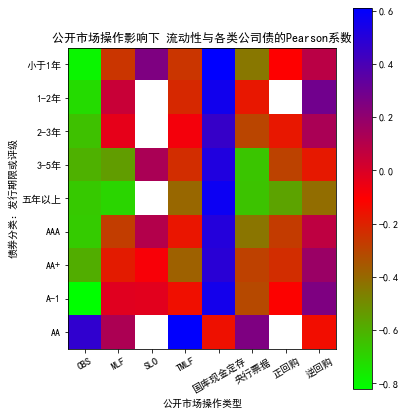

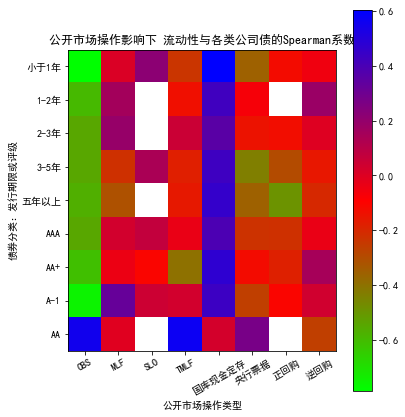

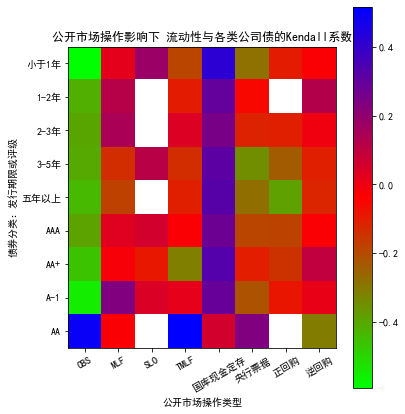

In [39]:
all_results = {}
for c in ['Pearson', 'Spearman', 'Kendall']:
    res = results(c, b_names, Oprt_taxis)
    all_results[c] = res

In [45]:
all_results['Kendall']

,CBS,MLF,SLO,TMLF,国库现金定存,央行票据,正回购,逆回购
小于1年,-0.591633,0.021573,0.179699,-0.185114,0.420908,-0.283468,-0.095797,-0.027687
1-2年,-0.417379,0.118256,NaN,-0.097638,0.298624,-0.054840,NaN,0.123011
2-3年,-0.393930,0.144226,NaN,0.036261,0.255848,-0.115375,-0.103890,-0.006120
3-5年,-0.404369,-0.134931,0.115667,-0.135434,0.315005,-0.341243,-0.235879,-0.106576
五年以上,-0.437141,-0.179347,NaN,-0.104920,0.330209,-0.278269,-0.387233,-0.118368
AAA,-0.389393,0.030955,0.061047,-0.028711,0.282602,-0.187392,-0.181186,-0.027118
AA+,-0.457818,-0.022912,-0.085864,-0.311500,0.334313,-0.098957,-0.149293,0.100758
A-1,-0.549268,0.235193,0.040443,0.018412,0.295027,-0.215232,-0.084096,0.014053
AA,0.497245,-0.028172,NaN,0.516398,0.061721,0.239046,NaN,-0.309890


不同相关系数对结果定性分析影响不大。由此可以得到以下结论：
1. 除AA级债券，其他公司债发行利率与CBS导致的市场流动性呈负相关：市场流动性低，债券利率高；反之，利率低；  
CBS与小于一年、A-1级债的相关性更显著。
2. 除AA级，各类债券利率与逆回购影响下流动性也呈负相关，但只有A-1级较显著。
3. 除AA级，各类债券利率与国库现金定存影响下流动性呈正相关。
3. AA级债券利率与市场流动性变化往往与其他债券不同：与CBS、TMLF对流动性的影响呈较显著的正相关：流动相较高时，债券利率较高；流动性低，债券利率也高。
4. 长期债券（3-5年、5年以上）利率与央行票据、正回购呈不显著的负相关。
5. 其他情况下，流动性与各类债券利率没有显著相关性。

# 结果分析

对流动性影响相似的政策对同类债券利率的影响可能是不一样的，这可能与操作特有的现金流规模、发行期限有关。

In [27]:
OMO['期限'] = OMO['期限'].map(terms)
OMO['发行总量(亿元)'] = OMO['发行总量(亿元)'].apply(lambda s: s.replace(',', '')).map(float)

In [28]:
avg_amt = {}
avg_term = {}
iss_time = {}
for oprt in OMO.groupby('操作类型'):
    avg_amt[oprt[0]] = oprt[1]['发行总量(亿元)'].map(float).mean()
    avg_term[oprt[0]] = oprt[1]['期限'].map(float).mean()
    iss_time[oprt[0]] = len(oprt[1])

In [29]:
print('各类市场操作平均现金规模', avg_amt)
print('\n')
print('各类市场操作平均期限', avg_term)
print('\n')
print('各类市场操作次数', iss_time)

各类市场操作平均现金规模 {'CBS': 49.51807228915663, 'MLF': 2458.6363636363635, 'SLO': 937.8947368421053, 'TMLF': 2238.4, '国库现金定存': 621.8085106382979, '央行票据': 247.1639344262295, '正回购': 342.69102990033224, '逆回购': 559.7029952177196}


各类市场操作平均期限 {'CBS': 103.01204819277109, 'MLF': 296.59090909090907, 'SLO': 4.315789473684211, 'TMLF': 360.0, '国库现金定存': 110.42553191489361, '央行票据': 534.8360655737705, '正回购': 31.159468438538205, '逆回购': 11.610621696451044}


各类市场操作次数 {'CBS': 83, 'MLF': 264, 'SLO': 57, 'TMLF': 10, '国库现金定存': 188, '央行票据': 122, '正回购': 301, '逆回购': 3973}


尽管不具有很高的资金规模和长操作期限，CBS直接向商业银行提供了资金，且促进市场对商业银行永续债的购买，商业银行持续持有资金而无需还债，市场流动性受到较大影响，故债券利率受其影响大。

MLF和TMLF资金规模较大，但不直接向市场投放基础货币，更多起着稳定利率的作用，故债券利率与其相关性不高。

根据Pearson相关性结果：期限在3-5年与5年以上的债券则与MLF、TMLF相关性较强，这可能是因为在利率相对稳定的时候，长期债券更倾向于发行。

国库现金定存、央行票据、正逆回购的流动性影响均与债券利率呈现一定程度的正相关。

In [32]:
len(BoC[BoC['最新债项评级'] == 'AA'])

9

AA级债券在记录中发行量过少，故其发行利率与流动性的正相关性可能具有偶然性。